# Tracking Bugs

_Brief abstract/introduction/motivation.  State what the chapter is about in 1-2 paragraphs._
_Then, have an introduction video:_

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [2]:
import bookutils

In [3]:
import Intro_Debugging

In [4]:
import os

In [5]:
# ignore
# 
# WARNING: Unlike the other chapters in this book, 
# this chapter should NOT BE RUN AS A NOTEBOOK:
# 
# * It will delete ALL data from an existing 
#   local _RedMine_ installation.
# * It will create new users and databases in an existing
#   local _MySQL_ installation.
# 
# The only reason to run this notebook is to create the book chapter,
# which is the task of Andreas Zeller.
# If you are not Andreas, you should exactly know what you are doing.

assert os.getenv('USER') == 'zeller'

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Tracking import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:



## A Change Tracker

We have a look at the _Redmine_ change tracking system.

### Excursion: Setting up Redmine

To install Redmine, we followed the instructions at https://gist.github.com/johnjohndoe/2763243.
These final steps initialize the database:

In [6]:
import subprocess

In [7]:
import os
import sys

In [8]:
def with_ruby(cmd, inp='', show_stdout=False):
    shell = subprocess.Popen(['/bin/sh', '-c', f'''rvm_redmine=$HOME/.rvm/gems/ruby-2.7.2@redmine; \
rvm_global=$HOME/.rvm/gems/ruby-2.7.2@global; \
export GEM_PATH=$rvm_redmine:$rvm_global; \
export PATH=$rvm_redmine/bin:$rvm_global/bin:$HOME/.rvm/rubies/ruby-2.7.2/bin:$HOME/.rvm/bin:$PATH; \
cd $HOME/lib/redmine && {cmd}'''],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE,
                             universal_newlines=True)
    stdout_data, stderr_data = shell.communicate(inp)
    print(stderr_data, file=sys.stderr, end="")
    if show_stdout:
        print(stdout_data, end="")

In [9]:
def with_mysql(cmd, show_stdout=False):
    sql = subprocess.Popen(["mysql", "-u", "root",
                           "--default-character-set=utf8mb4"],
                            stdin=subprocess.PIPE,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE, 
                            universal_newlines=True)
    stdout_data, stderr_data = sql.communicate(cmd + ';')
    print(stderr_data, file=sys.stderr, end="")
    if show_stdout:
        print(stdout_data, end="")

In [10]:
with_ruby("bundle install --without development test")

[DEPRECATED] The `--without` flag is deprecated because it relies on being remembered across bundler invocations, which bundler will no longer do in future versions. Instead please use `bundle config set without 'development test'`, and stop using this flag
The dependency tzinfo-data (>= 0) will be unused by any of the platforms Bundler is installing for. Bundler is installing for ruby but the dependency is only for x86-mingw32, x64-mingw32, x86-mswin32. To add those platforms to the bundle, run `bundle lock --add-platform x86-mingw32 x64-mingw32 x86-mswin32`.
The dependency ffi (>= 0) will be unused by any of the platforms Bundler is installing for. Bundler is installing for ruby but the dependency is only for x86-mingw32, x64-mingw32, x86-mswin32. To add those platforms to the bundle, run `bundle lock --add-platform x86-mingw32 x64-mingw32 x86-mswin32`.


In [11]:
with_ruby("mysql.server start")

2021-01-11T14:48:37.6NZ mysqld_safe A mysqld process already exists


In [12]:
with_mysql("drop database redmine")

In [13]:
with_mysql("drop user 'redmine'@'localhost'")

In [14]:
with_mysql("create database redmine character set utf8")

In [15]:
with_mysql("create user 'redmine'@'localhost' identified by 'my_password'")

In [16]:
with_mysql("grant all privileges on redmine.* to 'redmine'@'localhost'")

In [17]:
with_ruby("bundle exec rake generate_secret_token")

DEPRECATED: use MT_CPU instead of N for parallel test runs


In [18]:
with_ruby("RAILS_ENV=production bundle exec rake db:migrate")

DEPRECATED: use MT_CPU instead of N for parallel test runs


In [19]:
with_ruby("RAILS_ENV=production bundle exec rake redmine:load_default_data", '\n')

DEPRECATED: use MT_CPU instead of N for parallel test runs


### End of Excursion

### Excursion: Starting Redmine

In [20]:
import os
import time

In [21]:
from multiprocessing import Process

In [22]:
def run_redmine(port):
    with_ruby(f'exec rails s -e production -p {port} > redmine.log 2>&1')

In [23]:
def start_redmine(port=3000):
    process = Process(target=run_redmine, args=(port,))
    process.start()
    time.sleep(5)

    url = f"http://localhost:{port}"
    return process, url

In [24]:
redmine_process, redmine_url = start_redmine()

### End of Excursion

### Excursion: Remote Control with Selenium

We assume is that there is a set of *user interface elements* we can interact with.

[Selenium](https://www.seleniumhq.org) is a framework for testing Web applications by _automating interaction in the browser_.  Selenium provides an API that allows one to launch a Web browser, query the state of the user interface, and interact with individual user interface elements.  The Selenium API is available in a number of languages; we use the [Selenium API for Python](https://selenium-python.readthedocs.io/index.html).

A Selenium *web driver* is the interface between a program and a browser controlled by the program.

In [25]:
from selenium import webdriver

In [26]:
from selenium.webdriver.common.keys import Keys

The following code starts a Firefox browser in the background, which we then control through the web driver.

In [27]:
BROWSER = 'firefox'

**Note:** If you don't have Firefox installed, you can also set `BROWSER` to `'chrome'` to use Google Chrome instead.

In [28]:
# BROWSER = 'chrome'

When running this outside of Jupyter notebooks, the browser is _headless_, meaning that it does not show on the screen.

In [29]:
from bookutils import rich_output

In [30]:
HEADLESS = not rich_output()

In [31]:
def start_webdriver(browser=BROWSER, headless=HEADLESS, zoom=1.4):
    if browser == 'firefox':
        options = webdriver.FirefoxOptions()
    if browser == 'chrome':
        options = webdriver.ChromeOptions()

    if headless and browser == 'chrome':
        options.add_argument('headless')
    else:
        options.headless = headless

    # Start the browser, and obtain a _web driver_ object such that we can interact with it.
    if browser == 'firefox':
        # For firefox, set a higher resolution for our screenshots
        profile = webdriver.firefox.firefox_profile.FirefoxProfile()
        profile.set_preference("layout.css.devPixelsPerPx", repr(zoom))
        gui_driver = webdriver.Firefox(firefox_profile=profile, options=options)

        # We set the window size such that it fits
        gui_driver.set_window_size(500, 600)  # was 1024, 600

    elif browser == 'chrome':
        gui_driver = webdriver.Chrome(options=options)
        gui_driver.set_window_size(1024, 510 if headless else 640)

    return gui_driver

In [32]:
gui_driver = start_webdriver(browser=BROWSER, headless=HEADLESS)

We can now interact with the browser programmatically.  First, we have it navigate to the URL of our Web server:

In [33]:
gui_driver.get(redmine_url)

To see what the "headless" browser displays, we can obtain a screenshot.  We see that it actually displays the home page.

In [34]:
from IPython.display import display, Image

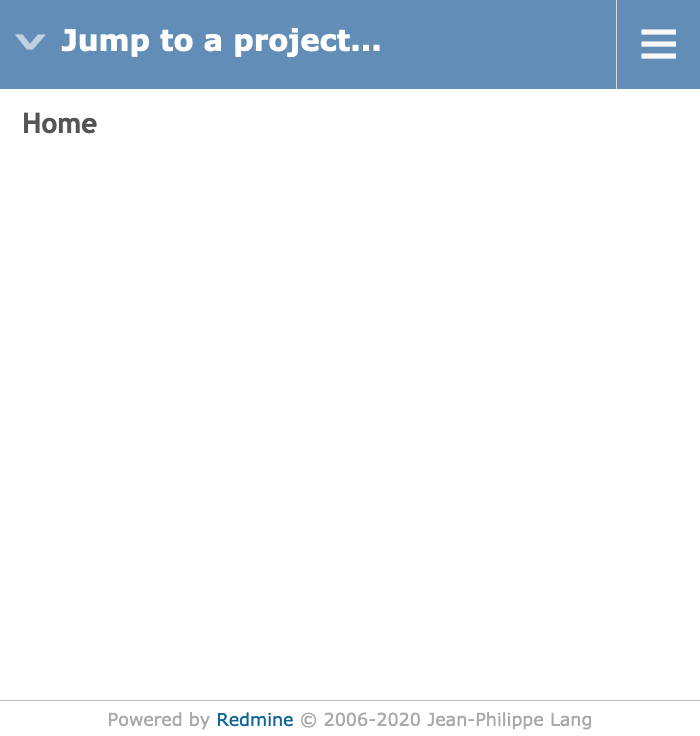

In [35]:
Image(gui_driver.get_screenshot_as_png())

### End of Excursion

### Excursion: Screenshots with Drop Shadows

By default, our screenshots are flat. We add a drop shadow to make them look nicer.
With help from https://graphicdesign.stackexchange.com/questions/117272/how-to-add-drop-shadow-to-a-picture-via-cli

In [36]:
import tempfile

In [37]:
def drop_shadow(contents):
    with tempfile.NamedTemporaryFile() as tmp:
        tmp.write(contents)
        convert = subprocess.Popen(
            ['convert', tmp.name,
            '(', '+clone', '-background', 'black', '-shadow', '50x10+15+15', ')',
            '+swap', '-background', 'none', '-layers', 'merge', '+repage', '-'],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout_data, stderr_data = convert.communicate()
    
    if stderr_data:
        print(stderr_data.decode("utf-8"), file=sys.stderr, end="")
        
    return stdout_data

In [38]:
def screenshot(driver):
    return Image(drop_shadow(gui_driver.get_screenshot_as_png()))

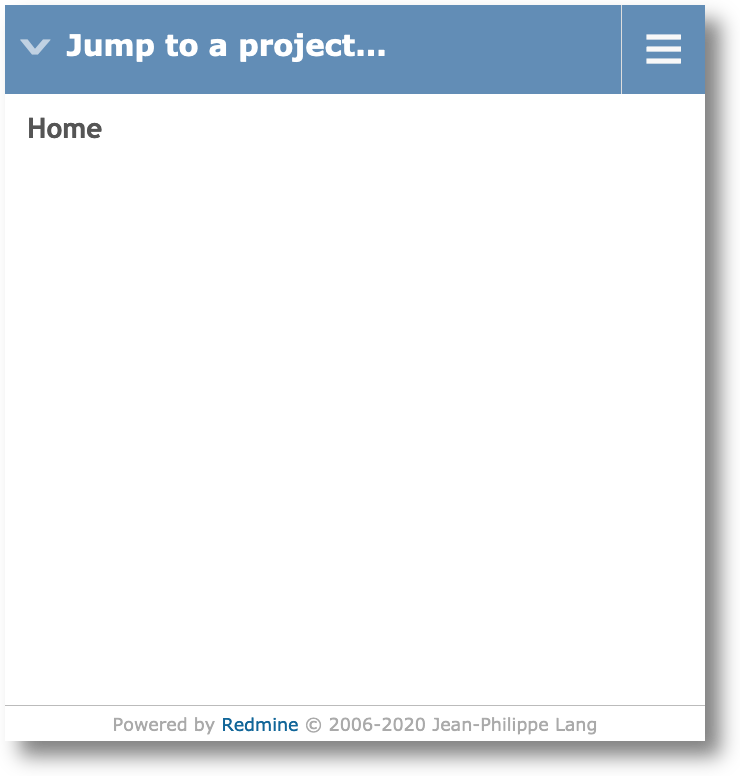

In [39]:
screenshot(gui_driver)

### End of Excursion

### Excursion: First Registration at Redmine

In [40]:
gui_driver.get(redmine_url + '/login')

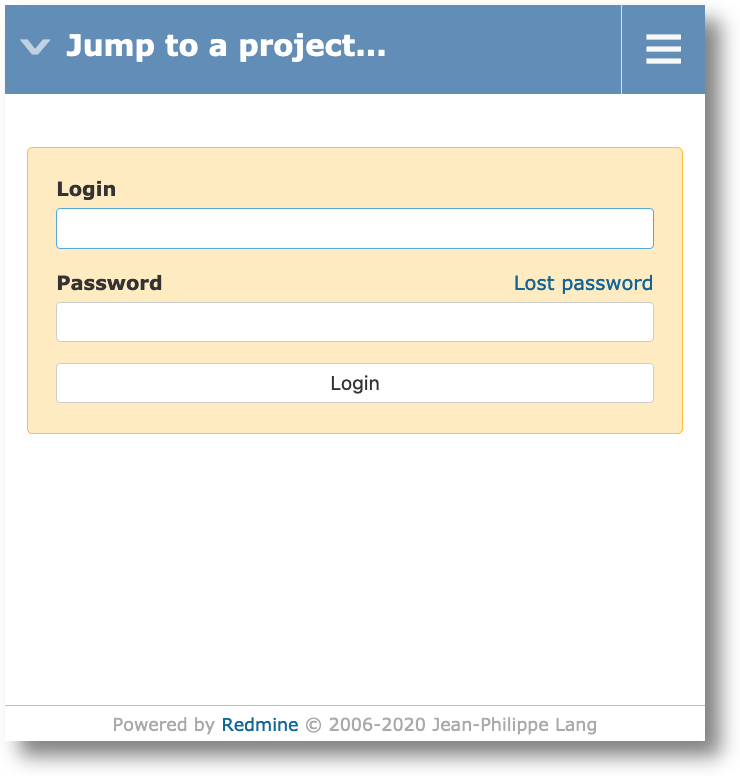

In [41]:
screenshot(gui_driver)

In [42]:
gui_driver.find_element_by_id("username").send_keys("admin")
gui_driver.find_element_by_id("password").send_keys("admin")
gui_driver.find_element_by_name("login").click()

In [43]:
time.sleep(2)

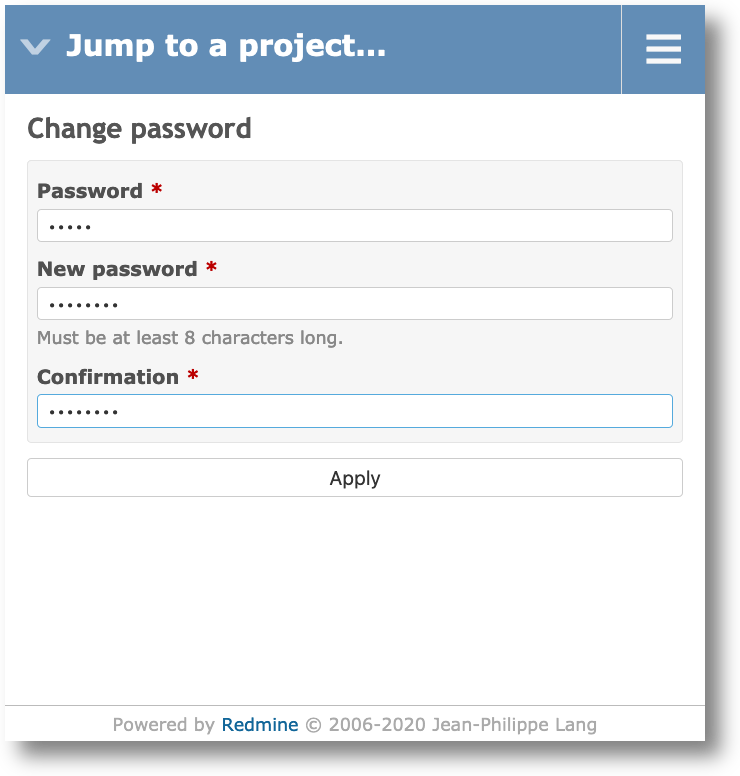

In [44]:
if gui_driver.current_url.endswith('my/password'):
    gui_driver.get(redmine_url + '/my/password')
    gui_driver.find_element_by_id("password").send_keys("admin")
    gui_driver.find_element_by_id("new_password").send_keys("admin001")
    gui_driver.find_element_by_id("new_password_confirmation").send_keys("admin001")
    display(screenshot(gui_driver))
    gui_driver.find_element_by_name("commit").click()

In [45]:
gui_driver.get(redmine_url + '/logout')
gui_driver.find_element_by_name("commit").click()

### End of Excursion

This is what the _Redmine_ tracker starts with:

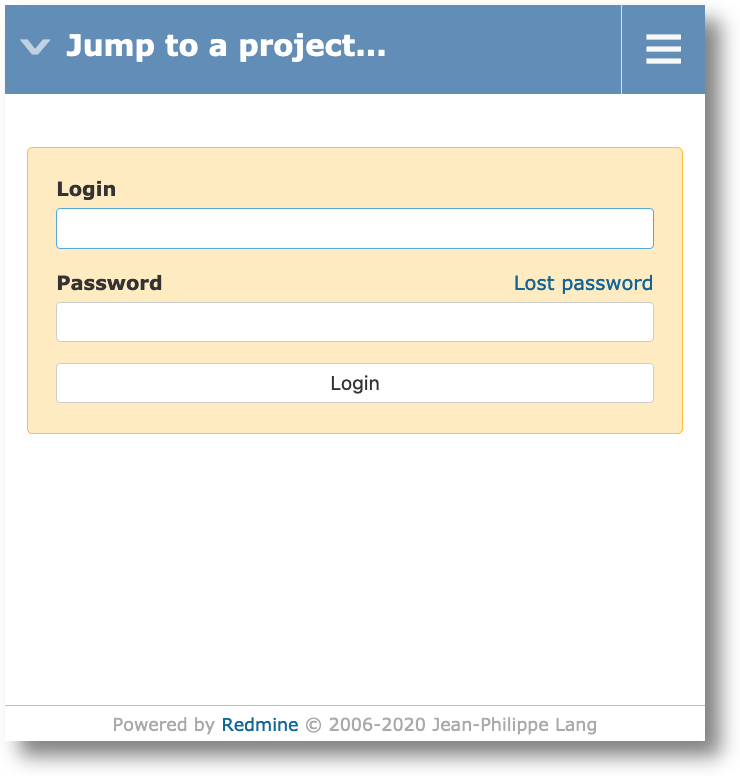

In [46]:
# ignore
gui_driver.get(redmine_url + '/login')
screenshot(gui_driver)

After we login, we see our account:

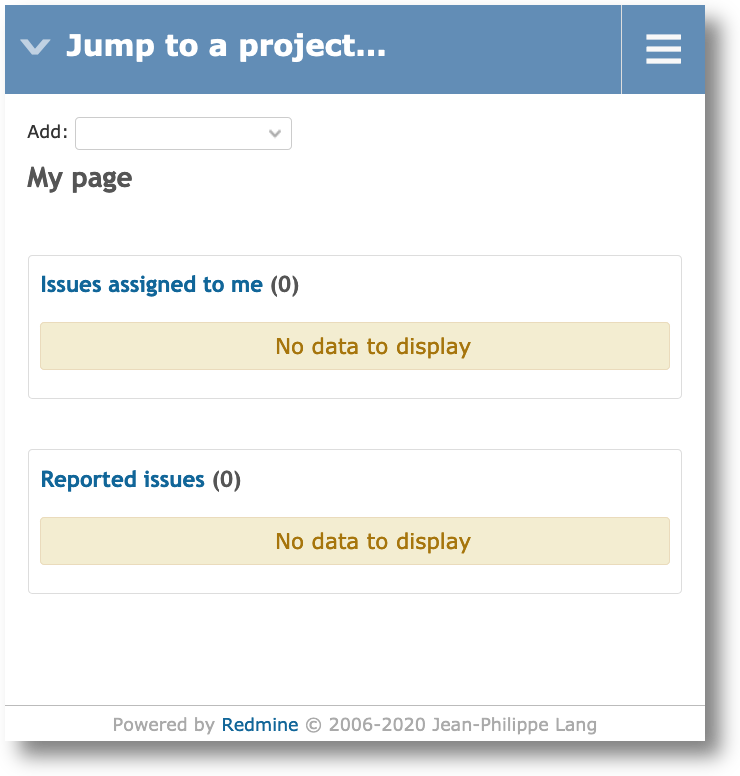

In [47]:
# ignore
gui_driver.find_element_by_id("username").send_keys("admin")
gui_driver.find_element_by_id("password").send_keys("admin001")
gui_driver.find_element_by_name("login").click()
screenshot(gui_driver)

### Excursion: Creating a Project

Let us check out the projects by clicking on "Projects".

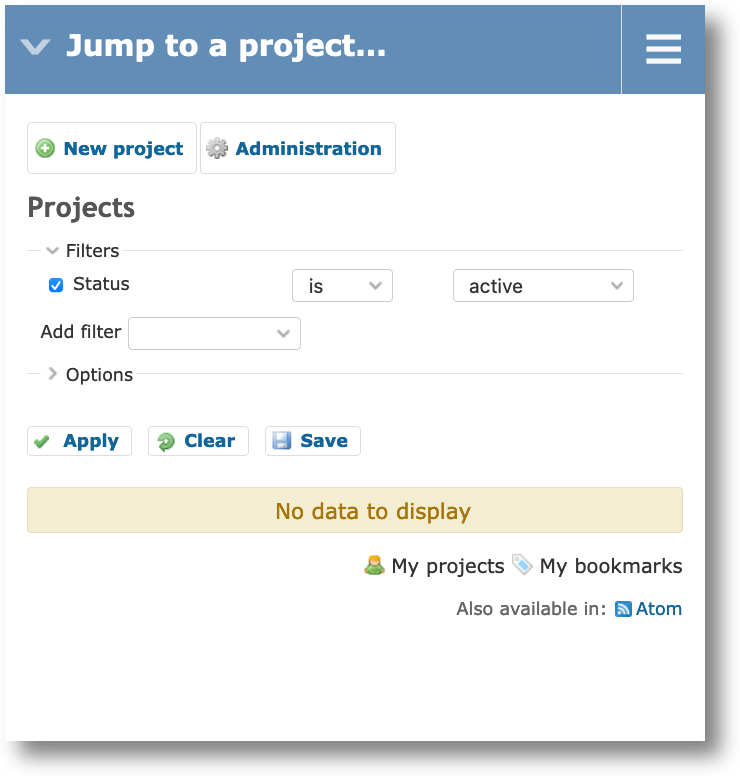

In [48]:
# ignore
gui_driver.get(redmine_url + '/projects')
screenshot(gui_driver)

Let us create a new project by clicking on "Projects".

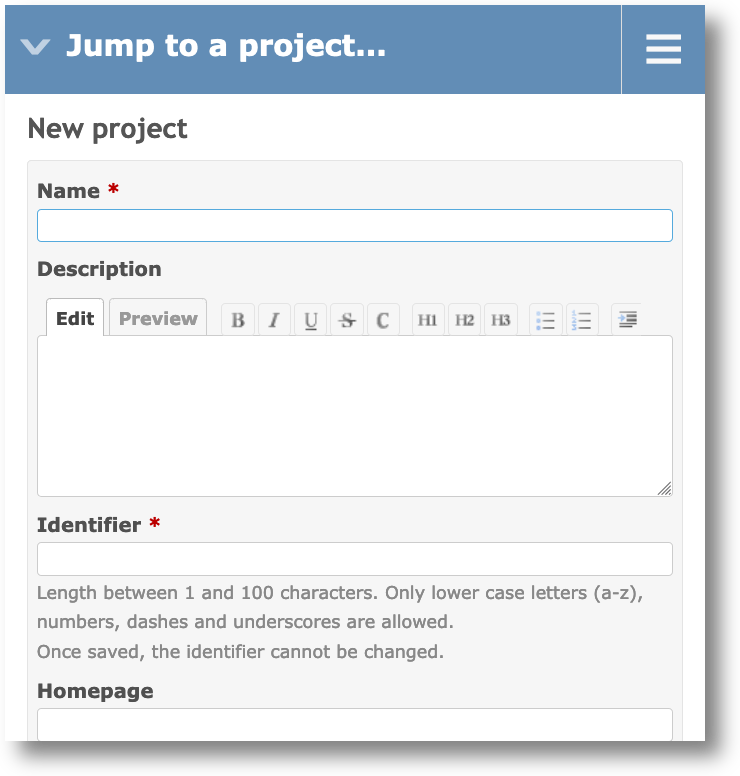

In [49]:
# ignore
gui_driver.get(redmine_url + '/projects/new')
screenshot(gui_driver)

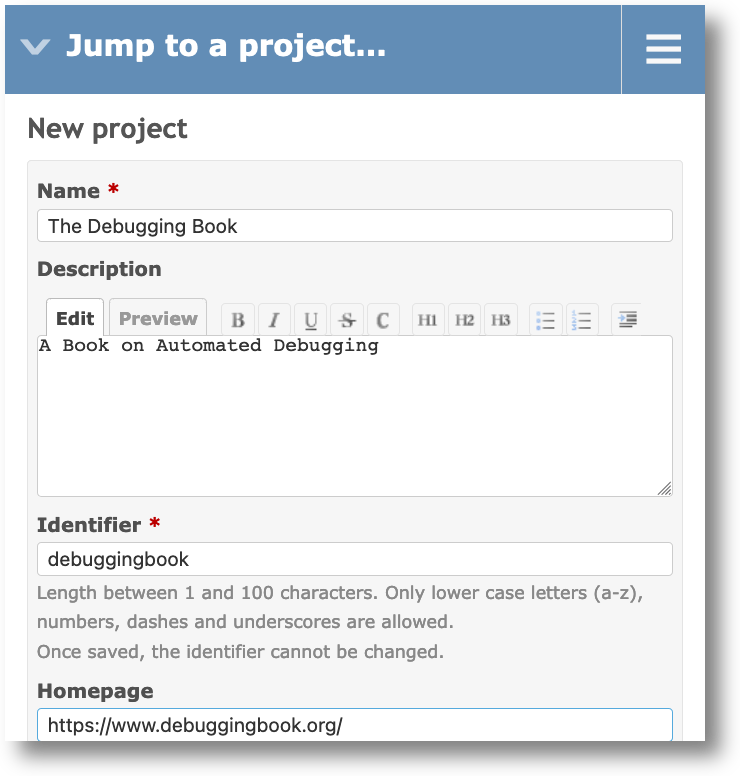

In [50]:
# ignore
gui_driver.get(redmine_url + '/projects/new')
gui_driver.find_element_by_id('project_name').send_keys("The Debugging Book")
gui_driver.find_element_by_id('project_description').send_keys("A Book on Automated Debugging")
gui_driver.find_element_by_id('project_identifier').clear()
gui_driver.find_element_by_id('project_identifier').send_keys("debuggingbook")
gui_driver.find_element_by_id('project_homepage').send_keys("https://www.debuggingbook.org/")
screenshot(gui_driver)

In [51]:
# ignore
gui_driver.find_element_by_name('commit').click()

### End of Excursion

We start with a list of projects.

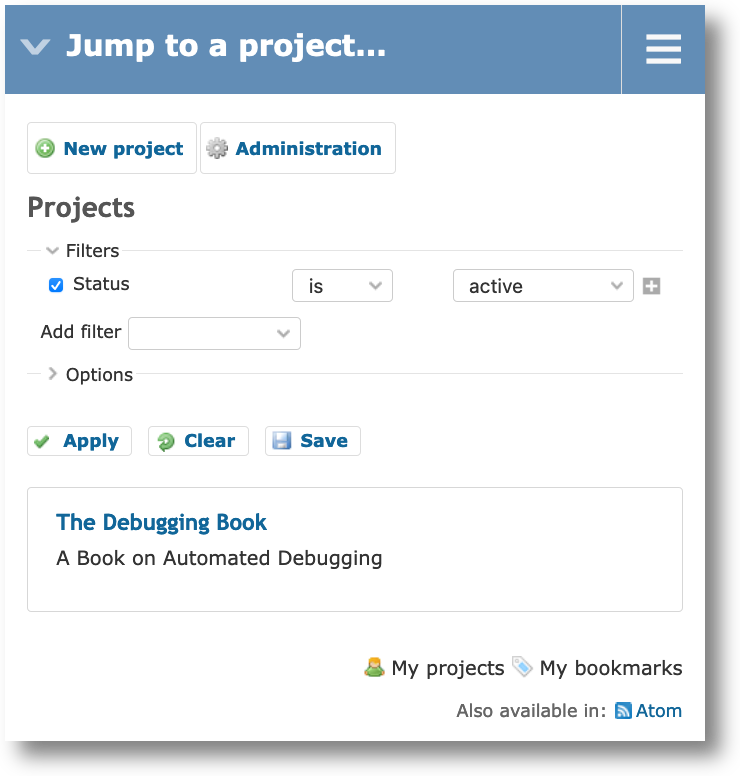

In [52]:
# ignore
gui_driver.get(redmine_url + '/projects')
screenshot(gui_driver)

Let us choose the (one) "debuggingbook" project.

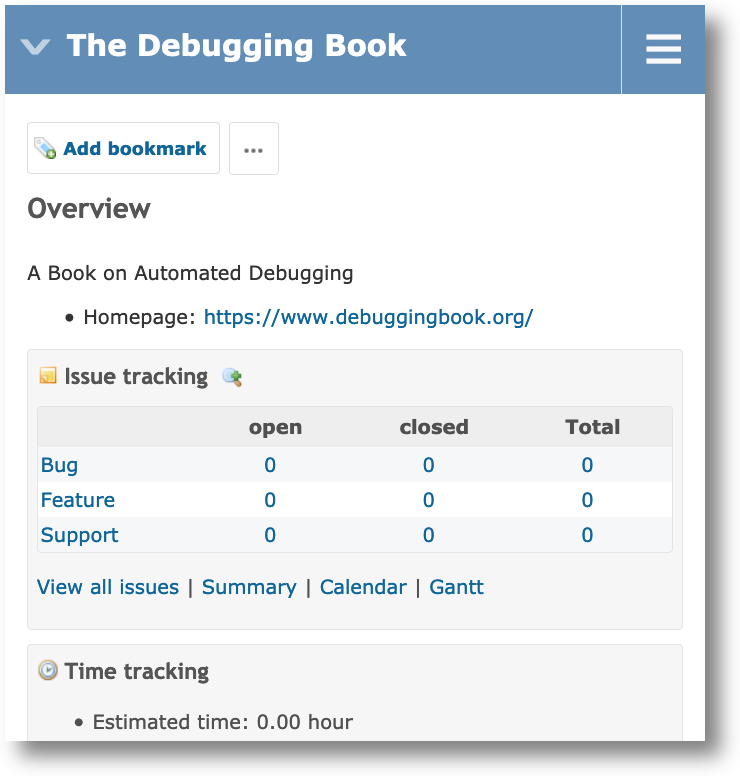

In [53]:
# ignore
gui_driver.get(redmine_url + '/projects/debuggingbook')
screenshot(gui_driver)

## Reporting a Bug

Let us file a new issue:

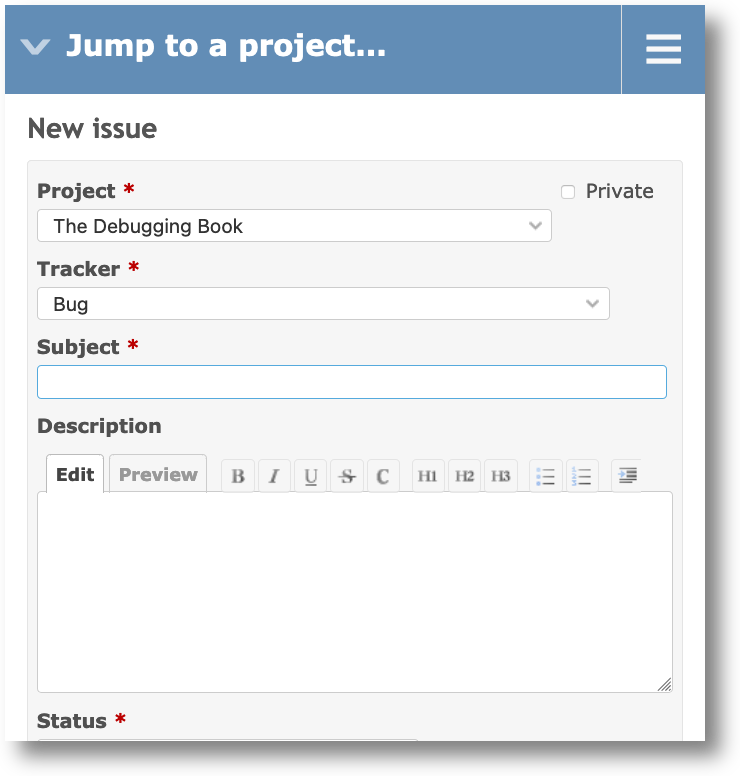

In [54]:
# ignore
gui_driver.get(redmine_url + '/issues/new')
screenshot(gui_driver)

Let's give our bug a name:

In [55]:
issue_title = "Does not render correctly on Nokia Communicator"

In [56]:
issue_description = \
"""The Debugging Book does not render correctly on the Nokia Communicator 9000.

Steps to reproduce:
1. On the Nokia, go to "https://debuggingbook.org/"
2. From the menu on top, select the chapter "Tracking Origins".
3. Scroll down to a place where a graph is supposed to be shown.
4. Instead of the graph, only a blank space is displayed.

How to fix:
* The graphs seem to come as SVG elements, but the Nokia Communicator
does not support SVG rendering. Render them as JPEGs instead.
"""

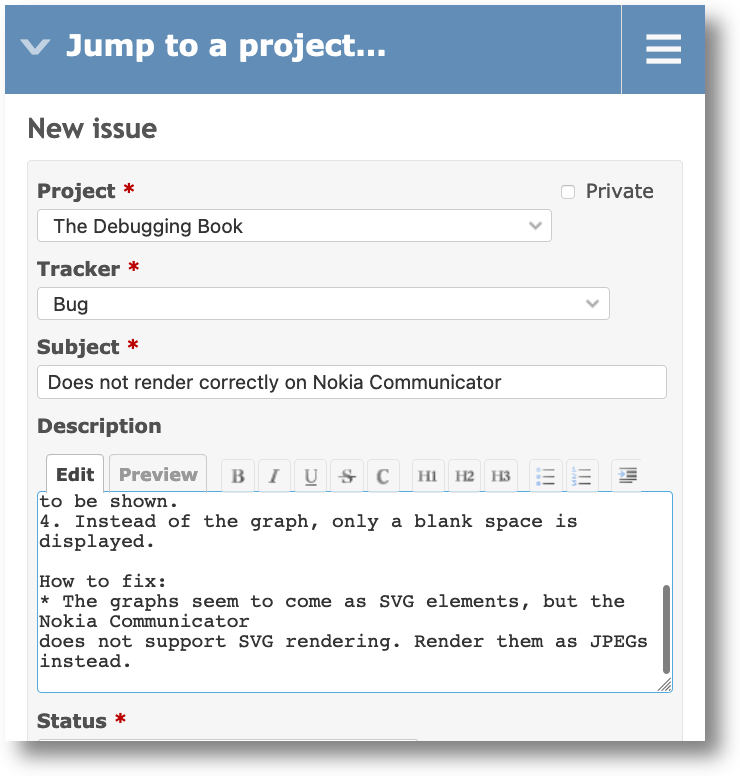

In [57]:
# ignore
gui_driver.get(redmine_url + '/issues/new')

gui_driver.find_element_by_id('issue_subject').send_keys(issue_title)
gui_driver.find_element_by_id('issue_description').send_keys(issue_description)
screenshot(gui_driver)

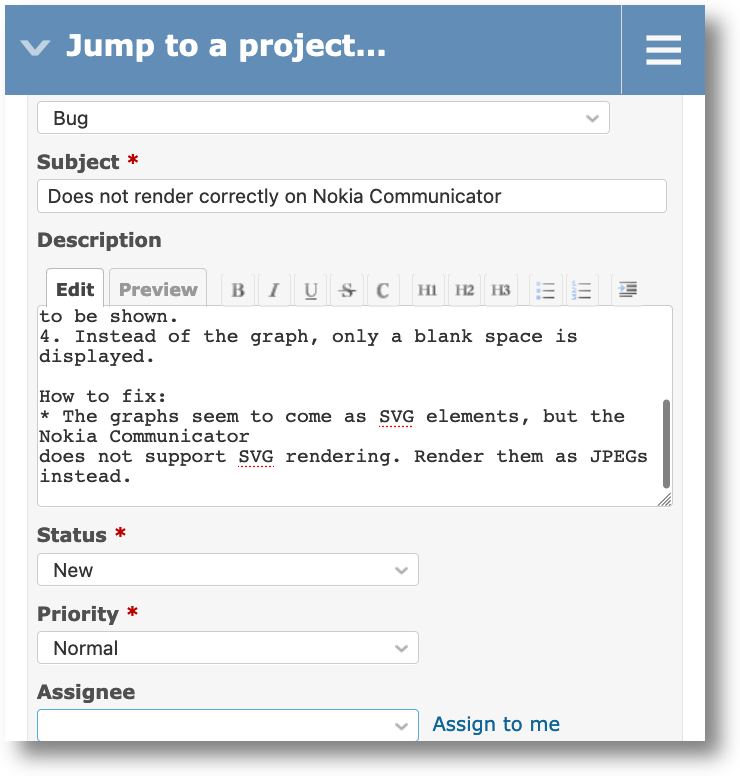

In [58]:
# ignore
gui_driver.find_element_by_id('issue_assigned_to_id').click()
screenshot(gui_driver)

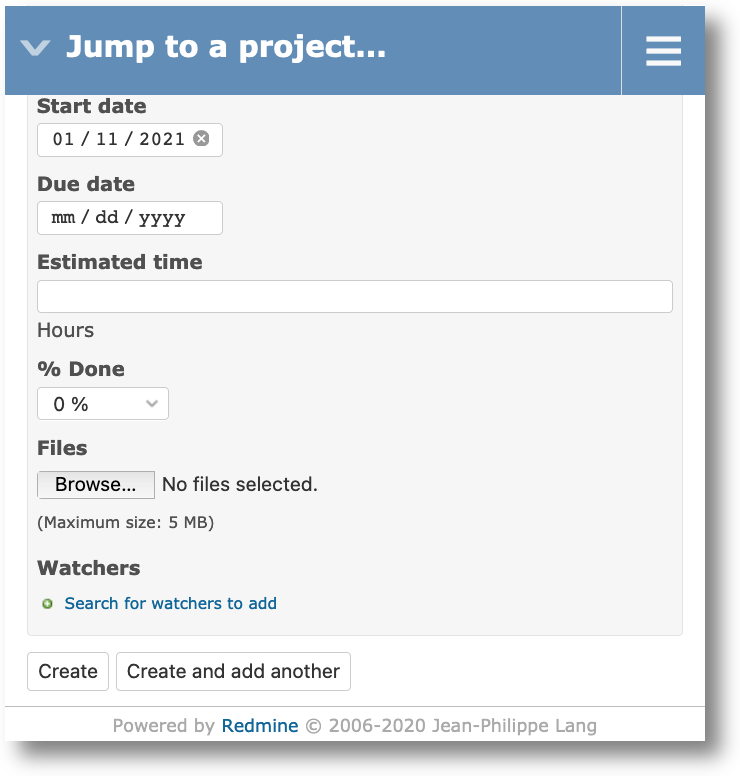

In [59]:
# ignore
gui_driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
screenshot(gui_driver)

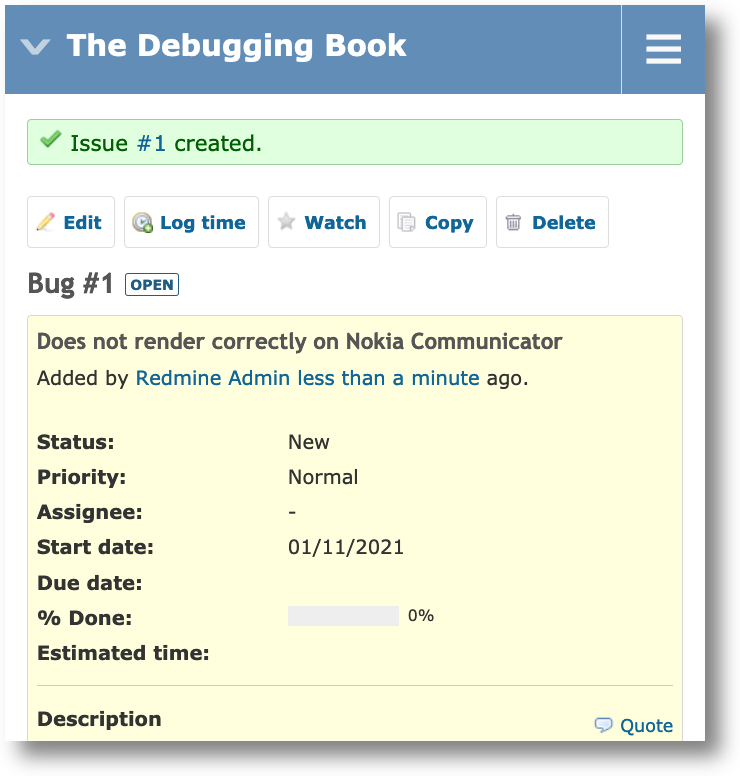

In [60]:
# ignore
gui_driver.find_element_by_name('commit').click()
screenshot(gui_driver)

## The Life Cycle of a Bug

We have successfully filed a bug. Now, this bug will enter the life cycle.

See also https://www.softwaretestinghelp.com/bug-life-cycle/

In [61]:
from Intro_Debugging import graph

In [62]:
from IPython.display import display

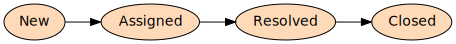

In [63]:
# ignore
life_cycle = graph()
# life_cycle.node('Unconfirmed')
life_cycle.node('New')
life_cycle.node('Assigned')
life_cycle.node('Resolved')
# life_cycle.node('Reopen')
# life_cycle.node('Verified')
life_cycle.node('Closed')

life_cycle.edge('New', 'Assigned')
life_cycle.edge('Assigned', 'Resolved')
life_cycle.edge('Resolved', 'Closed')

life_cycle

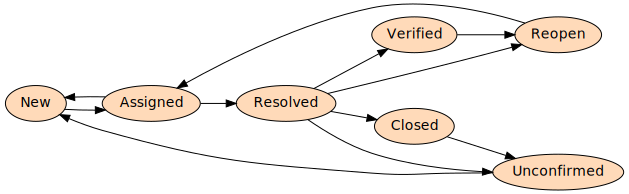

In [64]:
# ignore
life_cycle.node('Unconfirmed')
life_cycle.node('Reopen')
life_cycle.node('Verified')

life_cycle.edge('Unconfirmed', 'New')
life_cycle.edge('Assigned', 'New')
life_cycle.edge('Resolved', 'Verified')
life_cycle.edge('Resolved', 'Reopen')
life_cycle.edge('Resolved', 'Unconfirmed')
life_cycle.edge('Closed', 'Unconfirmed')
life_cycle.edge('Verified', 'Reopen')
life_cycle.edge('Reopen', 'Assigned')

life_cycle

### Assigning Bug Reports

## Prioritizing Bug Reports

To experiment with RedMine and other issue trackers yourself, pick one of the test installations:

* \todo{add}

## Cleanup

In [65]:
import os

In [66]:
redmine_process.terminate()

In [67]:
gui_driver.close()

In [68]:
os.system("pkill ruby")

0

## Synopsis

<!-- Automatically generated. Do not edit. -->



_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

```python
print(int_fuzzer())
```
```python
=> 76.5

```


## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [69]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [70]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_